# Couple a simple single column model to the `climlab.radiation.aplusbt.AplusBT_CO2` scheme and explore ECS

The thermal structure of the atmosphere is assumed to follow the pseudoadiabatic lapse rate in the troposphere, with an overlying isothermal stratosphere at a fixed tropopause temperature, following Seeley and Jeevanjee (2020).

In [1]:
%matplotlib inline 
import climlab
import numpy as np
from matplotlib import pyplot as plt
import scipy.integrate as sp  #Gives access to the ODE integration package
from attrdict import AttrDict

In [2]:
class Dummy:
    pass

params = Dummy()

params.eps   = 0.622 # molar mass ratio of vapour to total moist air
params.L     = 2260000 # Latent heat of vap, water, J/kg

params.R_a   = 287.058 # gas constant for dry air, J/kg/K
params.R_c   = 461.5  # gas constant for water vapour, J/kg/K
params.cp_a  = 1004 # specific heat capacity of air, J/kg/K

params.Tstrat = 200 # isothermal stratosphere, K

params.RH = 0.8 

In [3]:
# Define functions

def q(T, P): # specific humidity at saturation (using Clausius-Clapeyron)
    return climlab.utils.thermo.qsat(T, P)

def moist_adiabat(T, P): # Pressure coords gives dT/dP (if using the T/P prefactor)
    return np.divide(T, P) * np.divide(params.R_a, params.cp_a) * np.divide(1 + np.divide(params.L*q(T, P), params.R_a * T), 
                                                                            1 + np.divide(params.L**2 * q(T, P), params.cp_a * params.R_c * T**2))

# Or, equivalently...
def pseudoadiabat(T,p):
    return climlab.utils.thermo.pseudoadiabat(T, p)

def dry_adiabat(T):
    return np.divide(params.params.R_a, cp_a)

def generate_idealized_temp_profile(SST, Tstrat, plevs):
    solution = sp.odeint(pseudoadiabat, SST, np.flip(plevs))
    temp = solution.reshape(-1)
    temp[np.where(temp<Tstrat)] = Tstrat
    return np.flip(temp) # need to re-invert the pressure axis

In [4]:
def calc_olr_AplusBT(SST):
    ## climlab setup

    # create a column atmosphere and scalar surface
    sfc, atm = climlab.domain.single_column()

    # Create a state variable
    Ts = climlab.Field(SST, domain=sfc)

    # Make a dictionary of state variables
    s = {'Ts': Ts}

    # create process
    rad = climlab.radiation.AplusBT(state=s)
    rad.compute_diagnostics()

    return rad.OLR[0]

In [5]:
calc_olr_AplusBT(SST=15)

230.0

In [6]:
def calc_olr_AplusBT_CO2(SST, CO2ppmv):
    ## climlab setup
    # create surface and atmosperic domains
    #state = climlab.column_state(num_lev=30, num_lat=1, water_depth=1.)
    #plevs = state['Tatm'].domain.axes['lev'].points
    #state['Ts'][:] = SST
    #state['Tatm'][:] = generate_idealized_temp_profile(SST, params.Tstrat, plevs)

    # create a column atmosphere and scalar surface
    sfc, atm = climlab.domain.single_column()

    # Create a state variable
    # N.B. Assumes temp in C
    Ts = climlab.Field(SST+climlab.utils.constants.tempKtoC, domain=sfc)

    # Make a dictionary of state variables
    s = {'Ts': Ts}

    # AplusBT_co2
    rad = climlab.radiation.aplusbt.AplusBT_CO2(state=s,CO2=CO2ppmv)
    rad.compute_diagnostics()
    
    return rad.OLR[0]

In [7]:
calc_olr_AplusBT_CO2(SST=280, CO2ppmv=80)

227.61921792660598

In [8]:
OLR0 = calc_olr_AplusBT_CO2(SST=288,CO2ppmv=280)
OLR0

236.40177627672603

In [9]:
OLRS = np.zeros((10,10))

for idx1, temp in enumerate(np.linspace(280, 290, 10)):
    for idx2, co2 in enumerate(np.linspace(280, 1200, 10)):
        OLRS[idx1, idx2] = calc_olr_AplusBT_CO2(temp, co2)

/home/users/andreww/miniconda3/envs/ecsbump/lib/python3.7/site-packages/xarray/plot/utils.py:624: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = fig.colorbar(primitive, **cbar_kwargs)


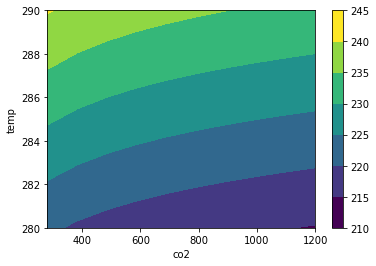

In [10]:
import xarray as xr
da=xr.DataArray(OLRS, dims=['temp', 'co2'], coords={'temp':np.linspace(280, 290, 10), 'co2':np.linspace(280, 1200, 10)})
da.plot.contourf()

# Calculate C-T$_{s}$ curve using `AplusBT_CO2` scheme

Loop over temperatures, and for each temperature then increment the CO$_{2}$  in 1ppmv intervals until the TOA LW energy budget is closed to within 0.2 Wm$^{-2}$ of its original value, OLR$_{0}$. 

In [11]:
"""
The loop to calculate the C-Ts curve takes ~10 minutes to run on a laptop with 
the RRTMG scheme, so you can either choose to run it or just set run_loop=False
and then it will load the data from the Data folder
"""

run_loop = True

Initial:  SST= 280 , CO2= 1 , TOA imbalance= 58.233  W/m2
Final:    SST= 280 , CO2= 27 , TOA imbalance= 0.133  W/m2
Initial:  SST= 281 , CO2= 27 , TOA imbalance= 2.315  W/m2
Final:    SST= 281 , CO2= 34 , TOA imbalance= 0.086  W/m2
Initial:  SST= 282 , CO2= 34 , TOA imbalance= 2.233  W/m2
Final:    SST= 282 , CO2= 43 , TOA imbalance= 0.114  W/m2
Initial:  SST= 283 , CO2= 43 , TOA imbalance= 2.229  W/m2
Final:    SST= 283 , CO2= 55 , TOA imbalance= 0.164  W/m2
Initial:  SST= 284 , CO2= 55 , TOA imbalance= 2.25  W/m2
Final:    SST= 284 , CO2= 72 , TOA imbalance= 0.164  W/m2
Initial:  SST= 285 , CO2= 72 , TOA imbalance= 2.22  W/m2
Final:    SST= 285 , CO2= 96 , TOA imbalance= 0.18  W/m2
Initial:  SST= 286 , CO2= 96 , TOA imbalance= 2.209  W/m2
Final:    SST= 286 , CO2= 132 , TOA imbalance= 0.157  W/m2
Initial:  SST= 287 , CO2= 132 , TOA imbalance= 2.16  W/m2
Final:    SST= 287 , CO2= 185 , TOA imbalance= 0.192  W/m2
Initial:  SST= 288 , CO2= 185 , TOA imbalance= 2.172  W/m2
Final:    SST=

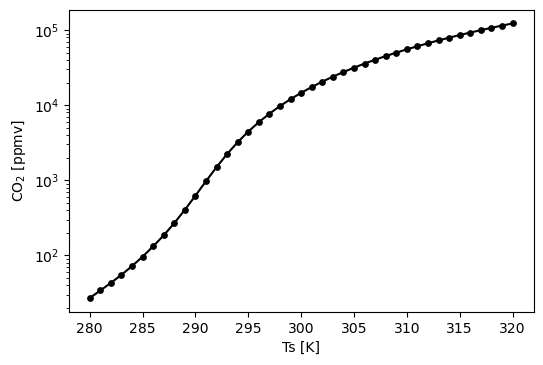

In [12]:
%%time

if run_loop:
    TEMPS = np.linspace(280, 320, 41)
    CO2_arr = np.zeros(len(TEMPS))

    OLR0 = calc_olr_AplusBT_CO2(SST=288,CO2ppmv=280)

    # n.b. require CO2>0 at all times because 
    # AplusBT_CO2 parameterization involves log(CO2/300)
    co2_init = 1

    for idx,sst in enumerate(TEMPS):

        if idx==0:
            co2_trial=co2_init

        olr = calc_olr_AplusBT_CO2(SST=sst,CO2ppmv=co2_trial)

        imbalance = np.round(np.abs(olr-OLR0),3)

        j=0
        while imbalance>0.2:

            if j==0:
                print('Initial: ', 'SST=',int(sst), ', CO2=',int(co2_trial), ', TOA imbalance=',imbalance,' W/m2')
                amplification = 1
                j=1

            dG = (np.sign(imbalance))
            co2_trial+=dG 

            if co2_trial<0:
                co2_trial=0

            olr = calc_olr_AplusBT_CO2(SST=sst,CO2ppmv=co2_trial)

            #imbalance = np.round(np.abs(olr-OLR0),3)
            imbalance = np.round(olr-OLR0,3)

        print('Final:   ', 'SST=',int(sst), ', CO2=',int(co2_trial), ', TOA imbalance=',imbalance,' W/m2')
        CO2_arr[idx] = int(co2_trial)
    
    # Save data
    C_Ts = xr.DataArray(CO2_arr, dims=['Ts'], 
                    coords={'Ts':xr.DataArray(TEMPS, dims=['Ts'], attrs={'units':'K'})},
                    attrs={'standard_name': 'CO$_{2}$', 'units': 'ppmv'})
    Ts_C = xr.DataArray(TEMPS, dims=['CO2'], 
                        coords={'CO2':xr.DataArray(CO2_arr, dims=['CO2'], attrs={'units':'ppmv'})},
                        attrs={'standard_name': 'Ts', 'units': 'K'})

    C_Ts.to_netcdf("./Data/C_Ts_curve_AplusBT_CO2.nc")
    Ts_C.to_netcdf("./Data/Ts_C_curve_AplusBT_CO2.nc")
        
    fig,ax=plt.subplots(dpi=100)
    C_Ts.plot(ax=ax, yscale='log', color='k')
    ax.scatter(C_Ts.Ts, C_Ts, color='k', s=15)
        
else:
    C_Ts = xr.open_dataarray("./Data/C_Ts_curve_AplusBT_CO2.nc")
    Ts_C = xr.open_dataarray("./Data/Ts_C_curve_AplusBT_CO2.nc")
    
    fig,ax=plt.subplots(dpi=100)
    C_Ts.plot(ax=ax, yscale='log', color='k')
    ax.scatter(C_Ts.Ts, C_Ts, color='k', s=15)

## Calculate the "inferred" ECS by interpolating along the C-T$_{s}$ curve

$$\mathrm{ECS}(\mathrm{T_{s}}) = \mathrm{T_{s}}(2\mathrm{x CO}_{2}) - \mathrm{T_{s}}(\mathrm{CO}_{2})$$

In [13]:
da_ECS = C_Ts.copy()
da_ECS.attrs = {'standard_name':'ECS', 'units': 'K'}
#da_ECS

In [14]:
for temp in da_ECS.Ts:
    conc = C_Ts.sel(Ts=temp)
    da_ECS.loc[dict(Ts=temp)] = Ts_C.interp(CO2=2*conc) - Ts_C.sel(CO2=conc) 

da_ECS
#da_ECS.to_netcdf("./Data/inferred_ECS_RRTMG.nc")

<xarray.DataArray (Ts: 41)>
array([2.91666667, 2.76470588, 2.58333333, 2.38888889, 2.22641509,
       2.08333333, 1.94047619, 1.74264706, 1.60454545, 1.53008596,
       1.52471483, 1.60458839, 1.77212614, 2.01468625, 2.27793534,
       2.58976881, 2.93877551, 3.28385965, 3.64779271, 4.02827624,
       4.39919049, 4.78623788, 5.1769263 , 5.5687401 , 5.97404551,
       6.37322619, 6.78403141, 7.19824985, 7.61589885, 8.04378474,
       8.46987794, 8.90748282,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan])
Coordinates:
  * Ts       (Ts) float64 280.0 281.0 282.0 283.0 ... 317.0 318.0 319.0 320.0
Attributes:
    standard_name:  ECS
    units:          K

Text(0.5, 1.05, 'Longwave scheme: A$_{(\\mathrm{CO}_{2})}$+B$_{(\\mathrm{CO}_{2})}$T')

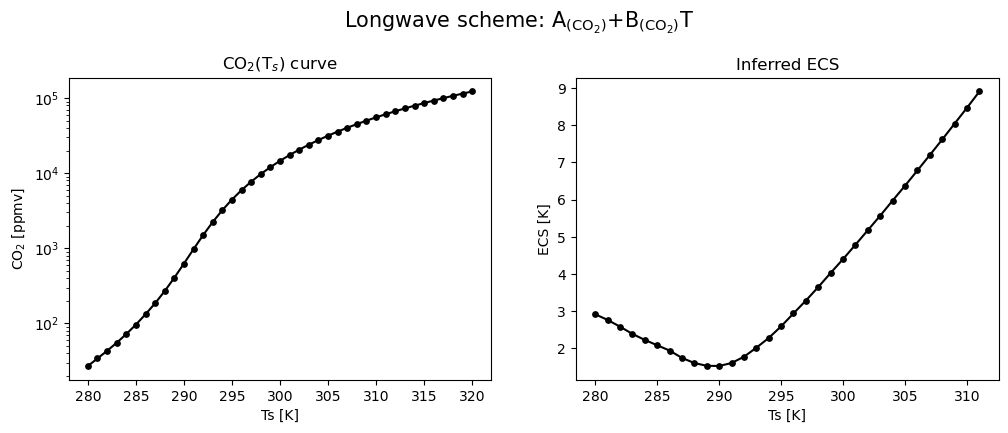

In [15]:
fig,axs=plt.subplots(ncols=2, figsize=(12,4), dpi=100)

C_Ts.plot(ax=axs[0], yscale='log', color='k')
axs[0].scatter(C_Ts.Ts, C_Ts, color='k', s=15)
axs[0].set_title(r"CO$_{2}$(T$_{s}$) curve")

da_ECS.plot(ax=axs[1], color='k')
axs[1].scatter(C_Ts.Ts, da_ECS, color='k', s=15)
axs[1].set_title(r"Inferred ECS")

fig.suptitle("Longwave scheme: A$_{(\mathrm{CO}_{2})}$+B$_{(\mathrm{CO}_{2})}$T", y=1.05, fontsize=15)

Text(0.5, 1.05, 'Longwave scheme: RRTMG_LW')

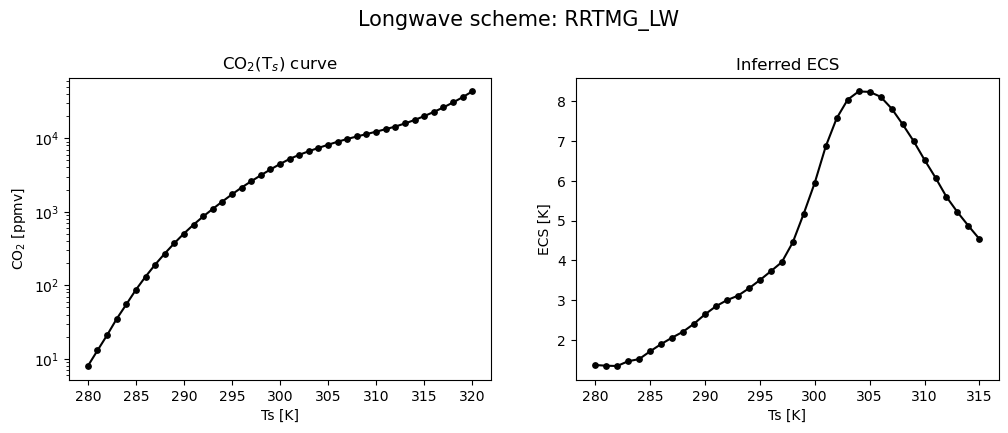

In [101]:
C_Ts_RRTMG = xr.open_dataarray("./Data/C_Ts_curve_RRTMG.nc")
Ts_C_RRTMG = xr.open_dataarray("./Data/Ts_C_curve_RRTMG.nc")

da_ECS_RRTMG = C_Ts_RRTMG.copy()
da_ECS_RRTMG.attrs = {'standard_name':'ECS', 'units': 'K'}

for temp in da_ECS_RRTMG.Ts:
    conc = C_Ts_RRTMG.sel(Ts=temp)
    da_ECS_RRTMG.loc[dict(Ts=temp)] = Ts_C_RRTMG.interp(CO2=2*conc) - Ts_C_RRTMG.sel(CO2=conc) 
    
fig,axs=plt.subplots(ncols=2, figsize=(12,4), dpi=100)

C_Ts_RRTMG.plot(ax=axs[0], yscale='log', color='k')
axs[0].scatter(C_Ts_RRTMG.Ts, C_Ts_RRTMG, color='k', s=15)
axs[0].set_title(r"CO$_{2}$(T$_{s}$) curve")

da_ECS_RRTMG.plot(ax=axs[1], color='k')
axs[1].scatter(C_Ts_RRTMG.Ts, da_ECS_RRTMG, color='k', s=15)
axs[1].set_title(r"Inferred ECS")

fig.suptitle("Longwave scheme: RRTMG_LW", y=1.05, fontsize=15)

## Add illustrative example point

In [103]:
Ts_ex = 307.
co2_ex = C_Ts.sel(Ts=Ts_ex).values
Ts_ex2=Ts_C.interp(CO2=2*co2_ex).values

Text(0.5, 1.04, 'Single-column model with A$_{(\\mathrm{CO}_{2})}$+B$_{(\\mathrm{CO}_{2})}$T scheme')

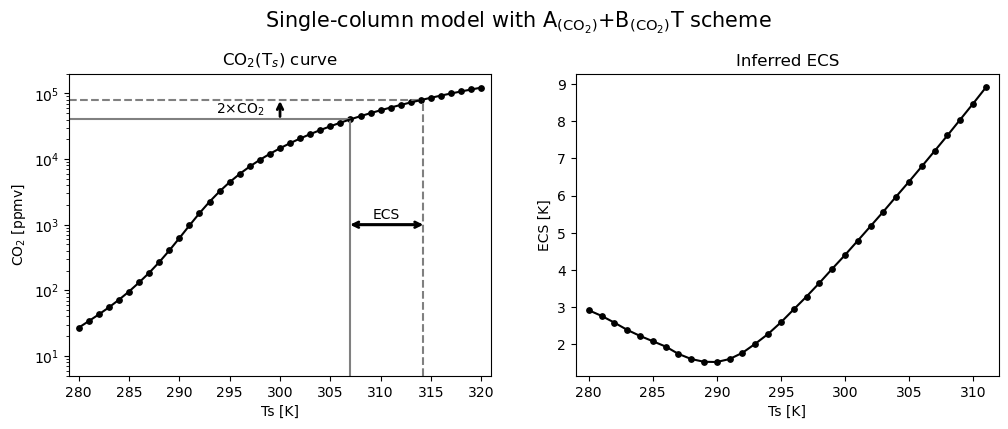

In [123]:
Tmin=279
Tmax=321
co2_min = 5
co2_max = 2e5
fig,axs=plt.subplots(ncols=2, figsize=(12,4), dpi=100)

axs[0].plot([Tmin,Ts_ex],co2_ex*np.ones(2),color='gray')
axs[0].plot([Tmin,Ts_ex2],2*co2_ex*np.ones(2),color='gray',linestyle='--')
axs[0].plot(Ts_ex*np.ones(2),[co2_min,co2_ex],color='gray')
axs[0].plot(Ts_ex2*np.ones(2),[co2_min,2*co2_ex],color='gray',linestyle='--')

axs[0].annotate("", xy=(Ts_ex/1.001, 1.e3), xytext=(Ts_ex2, 1.e3),
           arrowprops=dict(arrowstyle="->",lw=2,color='black'))
axs[0].annotate("", xy=(1.001*Ts_ex2, 1.e3), xytext=(Ts_ex, 1.e3),
           arrowprops=dict(arrowstyle="->",lw=2,color='black'))
axs[0].annotate("", xy=(300, 2.1*co2_ex), xytext=(300, co2_ex),
           arrowprops=dict(arrowstyle="->",lw=2,color='black'))

axs[0].text(0.5*(Ts_ex+Ts_ex2),1.25e3,'ECS',ha='center')
axs[0].text(296,np.sqrt(co2_ex*2*co2_ex),r'2$\times$CO$_2$',ha='center',va='center')

C_Ts.plot(ax=axs[0], yscale='log', color='k')
axs[0].scatter(C_Ts.Ts, C_Ts, color='k', s=15)
axs[0].set_xlim(Tmin, Tmax)
axs[0].set_ylim(co2_min, co2_max)
axs[0].set_title(r"CO$_{2}$(T$_{s}$) curve")

da_ECS.plot(ax=axs[1], color='k')
axs[1].scatter(C_Ts.Ts, da_ECS, color='k', s=15)
axs[1].set_xlim(Tmin, 312)
axs[1].set_title(r"Inferred ECS")

fig.suptitle("Single-column model with A$_{(\mathrm{CO}_{2})}$+B$_{(\mathrm{CO}_{2})}$T scheme", y=1.04, fontsize=15)

#plt.savefig('./Figs/Example_rrtmg_fig.png',facecolor='white', bbox_inches='tight', dpi=400)

### Calculate decomposition into F$_{2x}$ and $\lambda_{eff}$

$$\mathrm{F}_{2x}= \mathrm{OLR}(\mathrm{T}_{s}, \mathrm{C}) - \mathrm{OLR}(\mathrm{T}_{s}, 2*\mathrm{C})$$

$$\lambda_{\mathrm{eff}} = \frac{\mathrm{OLR}(\mathrm{T}_{s}+1, \mathrm{C}) - \mathrm{OLR}(\mathrm{T}_{s}, \mathrm{C})}{1\mathrm{K}}$$ 

In [113]:
da_F2x = C_Ts.copy()
da_F2x.attrs = {'standard_name':'CO2_F2x', 'units': 'W/m2'}
#da_F2x

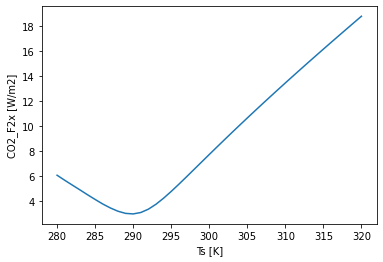

In [114]:
for temp in da_F2x.Ts:
    conc = C_Ts.sel(Ts=temp)
    da_F2x.loc[dict(Ts=temp)] = calc_olr_AplusBT_CO2(SST=temp.values,CO2ppmv=conc.values) - calc_olr_AplusBT_CO2(SST=temp.values,CO2ppmv=conc.values*2)
    
#sns.reset_orig()
da_F2x.plot()

In [115]:
da_lambda = C_Ts.copy()
da_lambda.attrs = {'standard_name':'Feedback_parameter', 'units': 'W/m2/K'}
#da_lambda

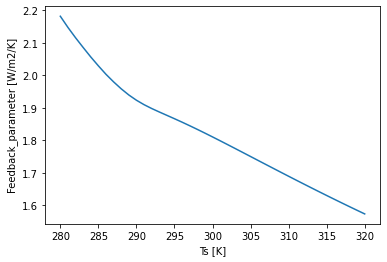

In [116]:
for temp in da_lambda.Ts:
    conc = C_Ts.sel(Ts=temp)
    da_lambda.loc[dict(Ts=temp)] = calc_olr_AplusBT_CO2(SST=temp.values+1,CO2ppmv=conc.values) - calc_olr_AplusBT_CO2(SST=temp.values,CO2ppmv=conc.values)
    

da_lambda.plot()

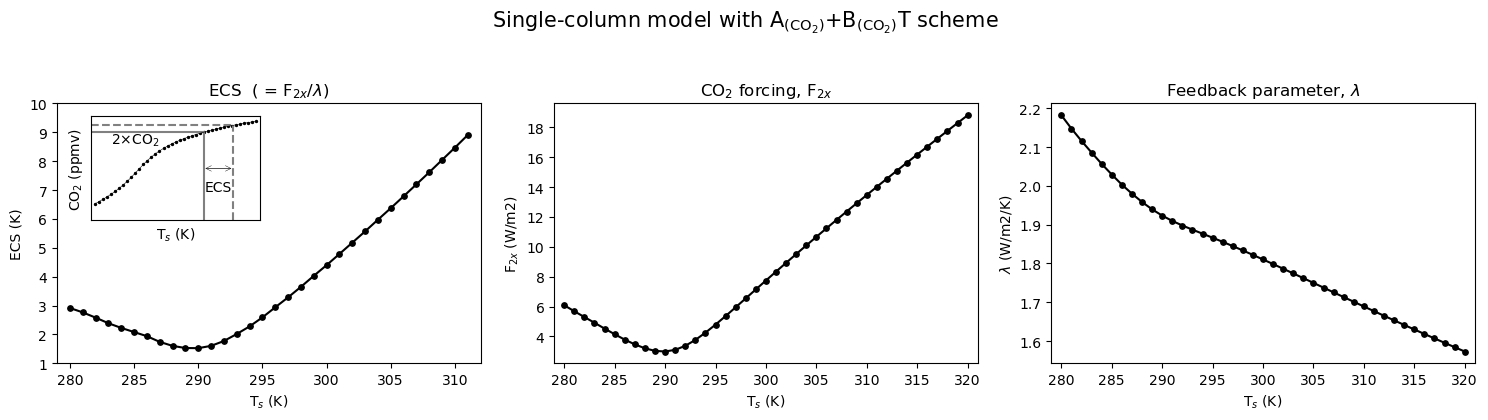

In [125]:
Tmin=279
Tmax=321
co2_min = 5
co2_max = 2e5
fig,axs=plt.subplots(ncols=3, figsize=(15,4), dpi=100)

axins = axs[0].inset_axes([0.08, 0.55, 0.4, 0.4], # x0, y0, width, height
                          transform=axs[0].transAxes) # ax[0].transAxes

axins.plot([Tmin,Ts_ex],co2_ex*np.ones(2),color='gray')
axins.plot([Tmin,Ts_ex2],2*co2_ex*np.ones(2),color='gray',linestyle='--')
axins.plot(Ts_ex*np.ones(2),[co2_min,co2_ex],color='gray')
axins.plot(Ts_ex2*np.ones(2),[co2_min,2*co2_ex],color='gray',linestyle='--')

axins.annotate("", xy=(Ts_ex/1.001, 1.e3), xytext=(Ts_ex2, 1.e3),
           arrowprops=dict(arrowstyle="->",lw=.3,color='black'))
axins.annotate("", xy=(1.001*Ts_ex2, 1.e3), xytext=(Ts_ex, 1.e3),
           arrowprops=dict(arrowstyle="->",lw=.3,color='black'))

C_Ts.plot(ax=axins, yscale='log', color='k', lw=0.4)
axins.scatter(C_Ts.Ts, C_Ts, color='k', s=2)
axins.set_xlim(Tmin, Tmax)
axins.set_ylim(co2_min, co2_max)

axins.text(0.5*(Ts_ex+Ts_ex2),1e2,'ECS',ha='center', fontsize=10)
axins.text(290,np.sqrt(co2_ex*0.2*co2_ex),r'2$\times$CO$_2$',ha='center',va='center', fontsize=10)
axins.set_xticks([])
axins.set_yticks([])
axins.set_xlabel("T$_{s}$ (K)")
axins.set_ylabel("CO$_{2}$ (ppmv)")


da_ECS.plot(ax=axs[0], color='k')
axs[0].scatter(C_Ts.Ts, da_ECS, color='k', s=15)
axs[0].set_xlim(Tmin, 312)
axs[0].set_ylim(1,10)
axs[0].set_title(r"ECS  ( = F$_{2x}$/$\lambda$)")
axs[0].set_ylabel("ECS (K)")


da_F2x.plot(ax=axs[1], color='k')
axs[1].scatter(C_Ts.Ts, da_F2x, color='k', s=15)
axs[1].set_title(r"CO$_{2}$ forcing, F$_{2x}$")
axs[1].set_xlim(Tmin, Tmax)
axs[1].set_ylabel(r"F$_{2x}$ (W/m2)")

da_lambda.plot(ax=axs[2], color='k')
axs[2].scatter(C_Ts.Ts, da_lambda, color='k', s=15)
axs[2].set_title("Feedback parameter, $\lambda$")
axs[2].set_xlim(Tmin, Tmax)
axs[2].set_ylabel(r"$\lambda$ (W/m2/K)")

for ax in axs:
    ax.set_xlabel("T$_{s}$ (K)")

fig.suptitle("Single-column model with A$_{(\mathrm{CO}_{2})}$+B$_{(\mathrm{CO}_{2})}$T scheme", y=1.04, fontsize=15)
fig.tight_layout()

#plt.savefig('./Figs/ECS_decomp_fig_AplusBT_CO2.png',bbox_inches='tight',facecolor='white', dpi=400)

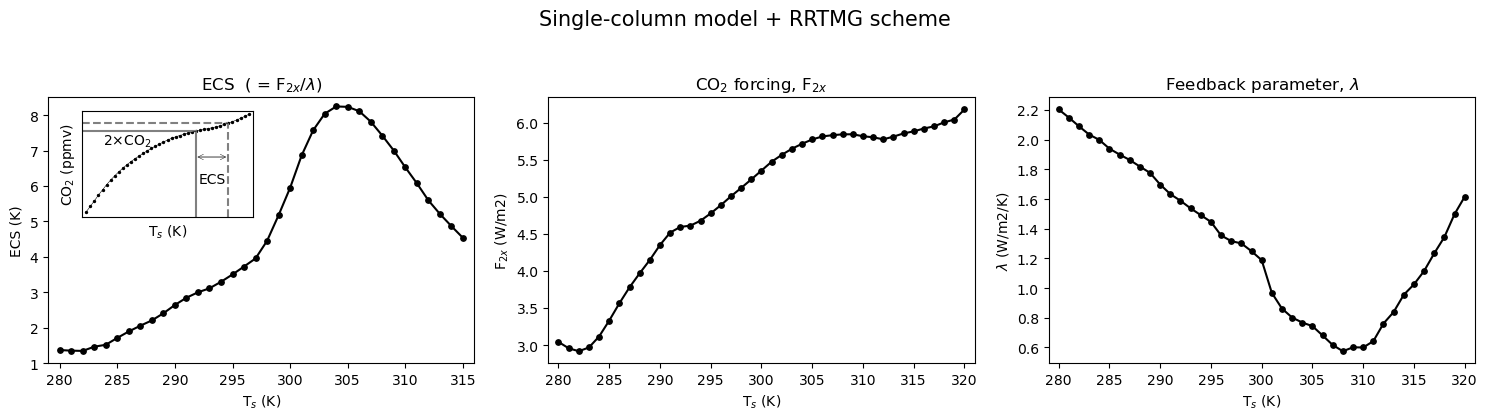

In [22]:
Tmin=279
Tmax=321
co2_min = 5
co2_max = 6e4
fig,axs=plt.subplots(ncols=3, figsize=(15,4), dpi=100)

axins = axs[0].inset_axes([0.08, 0.55, 0.4, 0.4], # x0, y0, width, height
                          transform=axs[0].transAxes) # ax[0].transAxes

axins.plot([Tmin,Ts_ex],co2_ex*np.ones(2),color='gray')
axins.plot([Tmin,Ts_ex2],2*co2_ex*np.ones(2),color='gray',linestyle='--')
axins.plot(Ts_ex*np.ones(2),[co2_min,co2_ex],color='gray')
axins.plot(Ts_ex2*np.ones(2),[co2_min,2*co2_ex],color='gray',linestyle='--')

axins.annotate("", xy=(Ts_ex/1.001, 1.e3), xytext=(Ts_ex2, 1.e3),
           arrowprops=dict(arrowstyle="->",lw=.3,color='black'))
axins.annotate("", xy=(1.001*Ts_ex2, 1.e3), xytext=(Ts_ex, 1.e3),
           arrowprops=dict(arrowstyle="->",lw=.3,color='black'))

C_Ts.plot(ax=axins, yscale='log', color='k', lw=0.4)
axins.scatter(C_Ts.Ts, C_Ts, color='k', s=2)
axins.set_xlim(Tmin, Tmax)
axins.set_ylim(co2_min, co2_max)

axins.text(0.5*(Ts_ex+Ts_ex2),1e2,'ECS',ha='center', fontsize=10)
axins.text(290,np.sqrt(co2_ex*0.2*co2_ex),r'2$\times$CO$_2$',ha='center',va='center', fontsize=10)
axins.set_xticks([])
axins.set_yticks([])
axins.set_xlabel("T$_{s}$ (K)")
axins.set_ylabel("CO$_{2}$ (ppmv)")


da_ECS.plot(ax=axs[0], color='k')
axs[0].scatter(C_Ts.Ts, da_ECS, color='k', s=15)
axs[0].set_xlim(Tmin, 316)
axs[0].set_ylim(1,8.5)
axs[0].set_title(r"ECS  ( = F$_{2x}$/$\lambda$)")
axs[0].set_ylabel("ECS (K)")


da_F2x.plot(ax=axs[1], color='k')
axs[1].scatter(C_Ts.Ts, da_F2x, color='k', s=15)
axs[1].set_xlim(Tmin, 316)
axs[1].set_title(r"CO$_{2}$ forcing, F$_{2x}$")
axs[1].set_xlim(Tmin, Tmax)
axs[1].set_ylabel(r"F$_{2x}$ (W/m2)")

da_lambda.plot(ax=axs[2], color='k')
axs[2].scatter(C_Ts.Ts, da_lambda, color='k', s=15)
axs[2].set_xlim(Tmin, 316)
axs[2].set_title("Feedback parameter, $\lambda$")
axs[2].set_xlim(Tmin, Tmax)
axs[2].set_ylabel(r"$\lambda$ (W/m2/K)")

for ax in axs:
    ax.set_xlabel("T$_{s}$ (K)")

fig.suptitle("Single-column model + RRTMG scheme", y=1.04, fontsize=15)
fig.tight_layout()

#plt.savefig('./Figs/ECS_decomp_fig.png',bbox_inches='tight',facecolor='white', dpi=400)